---
title: Classifying Palmer Penguins
author: Sophie Seiple
date: '2024-02-19'
image: "penguin.jpg"
description: "Finding a 100% accurate classification model for the palmer penguins dataset."
format: html
---

## Abstract


The aim of this post is to identify a machine learning model that can classify penguins as one of three species, Gentoo, Chinstrap, and Adelie, with 100% accuracy. I explore five different algorithms of classification: logistic regression, decision trees, random forests, support vector machine, and k-nearest neighbors. I use cross validation and grid-search cross validation to find the most accurate measurement of each model's effectiveness, and to avoid overfitting. I then compared the results of all five modelsto identify the most accurate model overall, which was a logistic regression model trained on either island, culmen length, culmen depth, or sex, culmen length, and culment depth. In the end I chose to train my final model on island, culmen length, and culmen depth, due to concerns about the real-world value of sex as a predictor for penguins.

## Data Preperation

In [1]:
import pandas as pd

train_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)

In [2]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(train)

In [3]:
X_train.head()

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,"Stage_Adult, 1 Egg Stage",Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
0,40.9,16.6,187.0,3200.0,9.08458,-24.54903,False,True,False,True,False,True,True,False
1,49.0,19.5,210.0,3950.0,9.53262,-24.66867,False,True,False,True,False,True,False,True
2,50.0,15.2,218.0,5700.0,8.25540,-25.40075,True,False,False,True,False,True,False,True
3,45.8,14.6,210.0,4200.0,7.79958,-25.62618,True,False,False,True,False,True,True,False
4,51.0,18.8,203.0,4100.0,9.23196,-24.17282,False,True,False,True,False,True,False,True


In [4]:
# changing species name for plotting ease
train["Species"] = train["Species"].str.split().str.get(0)

## Data Exploration

#### 1. SCATTER PLOT -- Delta 15 N and Delta 13 C

For my first graph, I chose to explore how delta 15 N values and delta 13 C values vary according to species.

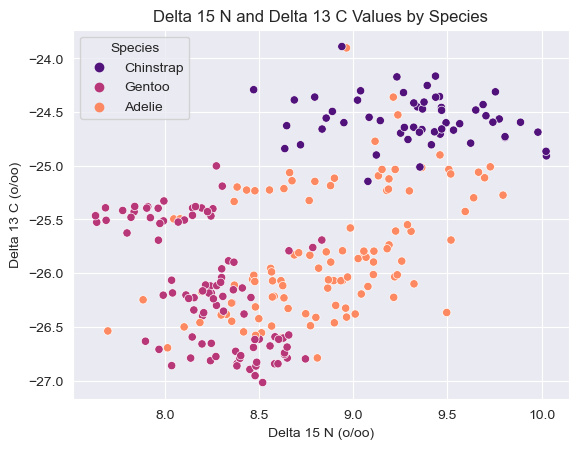

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")
sns.scatterplot(data=train, x='Delta 15 N (o/oo)', y='Delta 13 C (o/oo)', hue='Species', palette = "magma")
plt.title("Delta 15 N and Delta 13 C Values by Species")
plt.legend(title="Species", loc='upper left')

This graph shows the delta 15 N values and the delta 13 C values by species. Delta 15 N is a measure of the ratio between two stable nitrogen isotopes, nitrogen-15 and nitrogen-14. In biological contexts, this measure is often used to relative food chain position of an organism, with higher a higher value indicating a higher trophic position. Delta 13 C is a measure of the ratio between two stable carbon isotopes, carbon-13 and carbon-12. Delta 13 C is used in biology to analyze the diet of an organism, and can also be used to determine its trophic levels, with a higher delta 13 C value indicating greater productivity. Because chinstrap penguins have on average both a higher delta 15 n and delta 13 c value, this could indicate they exist slightly at a slightly higher trophic level, and consume food in a climate with a distinct inclination towards plants containing one carbon signature over the other. On the other hand adelie penguins seem to inhabit mostly an environment with a more balanced mix of the two in relation to chinstrap penguins, and gentoo penguins seems to be relatively skewed towards the other carbon signature. This would also indicate that adelie penguins are slightly lower in trophic level than chinstrap, and gentoo penguins even more so. For further exploration this raises the question of both relative sizes (body mass) of the penguins, and whether this agrees with the relative trophic levels seen here, and the islands on which the penguins are more likely to exist. For example does one island contain mostly chinstrap penguins and plants of one carbon signature while the other has mostly gentoo penguins and plants containing more of the other carbon signature.

#### 2. VIOLIN PLOT: BODY MASS BY SPECIES

For my second graph I wanted to explore the body mass distribution within the different species.

<Axes: title={'center': 'Body Mass by Species'}, xlabel='Species', ylabel='Body Mass (g)'>

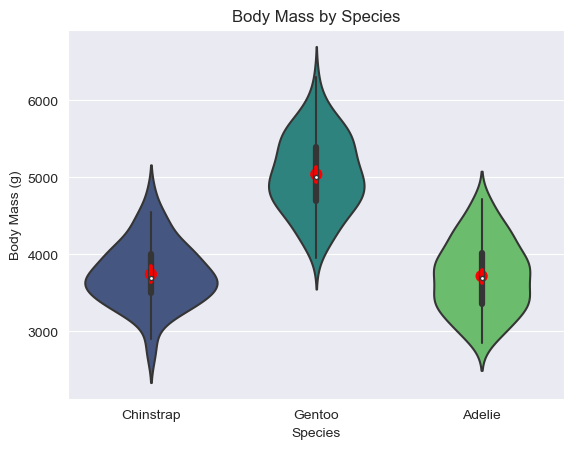

In [6]:
sns.violinplot(data = train, x="Species", y="Body Mass (g)", palette = "viridis")
plt.title("Body Mass by Species")
sns.pointplot(x="Species", y="Body Mass (g)", data=train, estimator='mean', color='red', markers='o', linestyles='')

This plot examines the body masses, and their relative frequency, within the three penguin species. The chinstrap figure shows that most chinstrap penguins fall within the interquartile range, and are very likely to exist near the median of the overall species body mass (shown in red). This contrasts somewhat with the adelie and gentoo penguins, who are not quite as densely centered around the median body mass of their species. This could be helpful in identifying chinstrap penguins in particular, as this tells us that a penguin with a body mass largely different from the chinstrap median is much less likely to be a chinstrap than a gentoo or an adelie. This plot is also interesting in terms of the derived trophic levels from the first figure, as it does not intuitively agree with the relative levels shown there. This could tell us that delta 15 N and delta 13 C might be less valuale predictors than we thought, as the patterns shown using these predictors are not necessarily reflected in other predictors.

#### 3. SUMMARY TABLE: SPECIES BY ISLAND

In [7]:
pd.crosstab(train['Species'], train['Island'])

Island,Biscoe,Dream,Torgersen
Species,,,
Adelie,33,45,42
Chinstrap,0,57,0
Gentoo,98,0,0


This table shows the relative counts of each of the three penguin species on the three islands surveyed. This table agrees with the patterns in delta 13 C values we saw in the first plot, as chinstrap and gentoo are found exclusively on Dream and Biscoe island respectively, which would confirm the hypothesis that the delta 13 C values vary according to a difference in the available plants carbon signatures. Adelie penguins, on the other hand, are found at all three islands, but also are the only penguins on Torgersen island, speaking to their relatively large variation in delta 13 C values.

## Creating the Model

First I created a dataframe that would later store the best, cross-validated values for each of the model types.

In [8]:
# creating dataframe to keep track of the max accuracies/best predictors for each algorithm
best_tracker = pd.DataFrame(columns = ['Logistic_Regression', 'Decision_Tree', 'Random_Forest', 'SVC', 'KNN'])
best_tracker.head()

,Logistic_Regression,Decision_Tree,Random_Forest,SVC,KNN


Then, using Professor Chodrow's code from the assignment description that generates every possible combination of two quantitative features and one qualitative feature, I created a loop that ran through the process of both fitting and cross-validating each model individually and storing the maximum result (in terms of accuracy and tuning parameters) to the previously created dataframe. For models with tuning parameters I used GridSearchCV to test many possible options for these parameters before finding the best one.

In [9]:
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC 
import numpy as np
from sklearn.neighbors import KNeighborsClassifier



all_qual_cols = ["Clutch Completion", "Sex", "Island", "Stage_Adult, 1 Egg Stage"] # qualitative columns
all_quant_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)'] # quantitative columns

# initialize all the trackers of the best model 
best_tree_score = 0
best_svc_score = 0
best_lr_score = 0
best_forest_score = 0
best_knn_score = 0

best_tree_depth = None
best_forest_depth = None
best_gamma = None
best_knn_neigh = None

best_tree_cols = []
best_svc_cols = []
best_lr_cols = []
best_forest_cols = []
best_knn_cols = []

#######################

# for each combination of 1 qualitative predictor and 2 quantitative predictors
for qual in all_qual_cols: 
  qual_cols = [col for col in X_train.columns if qual in col ]
  for pair in combinations(all_quant_cols, 2):
    cols = qual_cols + list(pair) 
    
    # LOGISTIC REGRESSION
    LR = LogisticRegression(max_iter=200000000000000) # was running into max. iterations reached error
    LR.fit(X_train[cols], y_train)
    cv_scores_LR = cross_val_score(LR, X_train[cols], y_train, cv=5) 
    curr_score = cv_scores_LR.mean() # mean of the cross valid. scores is considered the best score we can get w/ the model
    
    # update vars if necessary
    if curr_score > best_lr_score:
      best_lr_score = curr_score
      best_lr_cols = cols
    
    # DECISION TREE
    param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None] 
    } # None means no maximum depth, try a max. depth. Testing all depths from 1 to 10 (the total number of features) and no max. depth.
    tree = DecisionTreeClassifier()
    grid_search = GridSearchCV(tree, param_grid, cv=5)
    grid_search.fit(X_train[cols], y_train)
    curr_score = grid_search.best_score_ # mean of the cross valid. scores is considered the best score we can get w/ the model

    # update vars if necessary
    if curr_score > best_tree_score:
      best_tree_score = curr_score
      best_tree_cols = cols
      best_tree_depth = grid_search.best_params_

    # RANDOM FOREST
    param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None]
    } # same idea for max. depth as the decision tree
    forest = RandomForestClassifier(random_state=0)
    grid_search = GridSearchCV(forest, param_grid, cv=5)
    grid_search.fit(X_train[cols], y_train)
    curr_score = grid_search.best_score_ # mean of the cross valid. scores is considered the best score we can get w/ the model

    # update vars if necessary
    if curr_score > best_forest_score:
      best_forest_score = curr_score
      best_forest_cols = cols
      best_forest_depth = grid_search.best_params_

    # SVC
    g = {'gamma': 10.0**np.arange(-5, 5)} # testing all gammas in the range given in the blog post instructions
    grid_search = GridSearchCV(SVC(),g, cv = 5)
    grid_search.fit(X_train[cols],y_train)
    curr_score = grid_search.best_score_ # mean of the cross valid. scores is considered the best score we can get w/ the model

    # update vars if necessary
    if curr_score > best_svc_score:
      best_svc_score = curr_score
      best_svc_cols = cols
      best_gamma = grid_search.best_params_

    # K-NEAREST NEIGHBORS
    param_grid = {
    'n_neighbors': [5, 6, 7, 8, 9, 10]  
    }  # testing number of nearest neighbors from 5 to 10, didn't want groups to be too specialized or too generalized
    KNN = KNeighborsClassifier(n_neighbors=5)
    grid = GridSearchCV(KNN, param_grid, cv=5)
    grid.fit(X_train[cols], y_train)
    curr_score = grid.best_score_ # mean of the cross valid. scores is considered the best score we can get w/ the model

    # update vars if necessary
    if curr_score > best_knn_score:
      best_knn_score = curr_score
      best_knn_cols = cols
      best_knn_neigh = grid.best_params_
    
# update dataframe using the tracker variables for each model
best_tracker['Decision_Tree'] = [best_tree_score, best_tree_depth, best_tree_cols]
best_tracker['Logistic_Regression'] = [best_lr_score, None, best_lr_cols]
best_tracker['SVC'] = [best_svc_score, best_gamma, best_svc_cols]
best_tracker['Random_Forest'] = [best_forest_score, best_forest_depth, best_forest_cols]
best_tracker['KNN'] = [best_knn_score, best_knn_neigh, best_knn_cols]



/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The final dataframe shows the best results for each model, which shows that logistic regression was the most accurate model, with the parameters sex, culmen length, and culmen depth.

In [10]:
# best results for each of the five models
best_tracker.head()

,Logistic_Regression,Decision_Tree,Random_Forest,SVC,KNN
0,0.988311,0.976546,0.984465,0.980543,0.976621
1,None,{'max_depth': 5},{'max_depth': 5},{'gamma': 0.1},{'n_neighbors': 5}
2,"[Sex_FEMALE, Sex_MALE, Culmen Length (mm), Cul...","[Sex_FEMALE, Sex_MALE, Culmen Length (mm), Cul...","[Sex_FEMALE, Sex_MALE, Culmen Length (mm), Fli...","[Sex_FEMALE, Sex_MALE, Culmen Length (mm), Cul...","[Sex_FEMALE, Sex_MALE, Culmen Length (mm), Cul..."


## Testing the Model

In [11]:
# read in and prepare test data
test_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)


X_test, y_test = prepare_data(test)
test["Species"] = test["Species"].str.split().str.get(0)

Retraining and testing model with selected columns (1)

In [12]:
cols = ["Sex_FEMALE", "Sex_MALE", "Culmen Length (mm)", "Culmen Depth (mm)"]
LR1 = LogisticRegression(max_iter=20000000000000)
LR1.fit(X_train[cols], y_train)
LR1.score(X_test[cols], y_test)

0.9852941176470589

 NOTE: the last time I ran my code the parameter of sex gave me less than a 100% accuracy rate despite previously being 100%, but I moved ahead anyways because I chose island, which I explain below, and the model trained on those features still reached 100% accuracy.

Out of curiosity, I created a version of the dataframe that saved the best model and parameters for all of the features, which I have removed because of how long the code was and because I manually went through it to confirm a hypothesis. My hypothesis was that sex was not actually one of the best features for prediction, despite the dataframes finding, unless the data was skewed towards one sex or the other for a certain species, as biologically it says nothing about the species of a penguin to know its sex. When I looked through the data, I found that the logistic regression model using the island feature had an identical accuracy to the model fit to sex. This told me that the dataframe chose sex simply because they were tied and it was the latter one run, meaning the more recent model to reach the max accuracy. Scientifically, it makes more sense to train on island, as we've seen that certain penguins do inhabit certain islands at different rates, rather than sex which seems more like a quirk of the model. Therefore, I also fit a model to these three parameters and scored the predictions of this model.

In [13]:
# retraining and testing model with selected columns (2)
cols = ["Culmen Length (mm)", "Culmen Depth (mm)", "Island_Biscoe", "Island_Dream", "Island_Torgersen"]
LR = LogisticRegression(max_iter=20000000000000)
LR.fit(X_train[cols], y_train)
LR.score(X_test[cols], y_test)

1.0

I reached 100% accuracy using logisitic regression with the predictions parameters of sex, culmen length, and culmen depth, AND seperately with the prediction parameters of island, culmen length, and culment depth. Based on the context of predicting species, where sex is not a realistically valuable feature, I chose to move on using island instead.

## Plotting Decision Regions

In [14]:
from matplotlib import pyplot as plt
import numpy as np

Below is the code I used to graph the decision regions, adapted from Professor Chodrow's lecture notes.

In [15]:
from matplotlib.patches import Patch

def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (7, 3))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1], 
            title = qual_features[i])
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "best")
      
      plt.tight_layout()

The decision regions are shown split for each island, since they are seperated into three quantitative parameters, and the x-axis is the culmen length while the y-axis is the culmen depth.

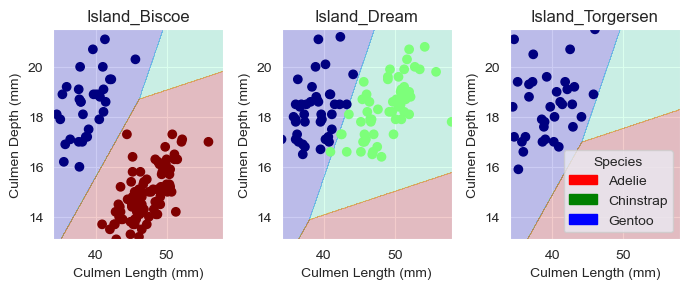

In [16]:
# plotting decision boundaries for model trained with island parameter
cols = ["Culmen Length (mm)", "Culmen Depth (mm)", "Island_Biscoe", "Island_Dream", "Island_Torgersen"]
plot_regions(LR, X_train[cols], y_train)

## Confusion Matrix

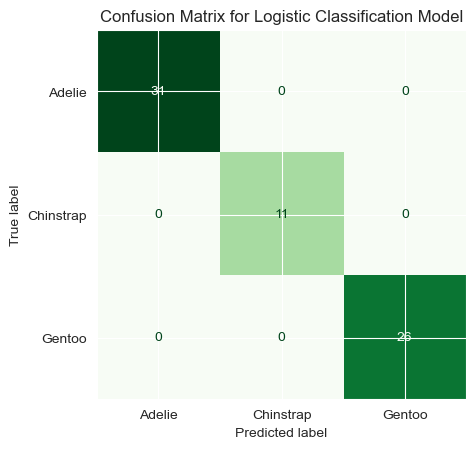

In [17]:
# creating confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = LR.predict(X_test[cols])
classes = ["Adelie", "Chinstrap", "Gentoo"]


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Greens, colorbar=False)
plt.title("Confusion Matrix for Logistic Classification Model")
plt.show()

The confusion matrix shows exactly what we would expect with a 100% accurate model, which is that all examples of each of the three species (31 for Adelie, 11 for Chinstrap, 26 for Gentoo) are correctly identified as their respective species.

## Discussion


The findings of this blogpost include a 100% accurate logistic classification model for determining whether a penguin, based on its sex/island, culmen length, and culmen depth, is an Adelie, Chinstrap, or Gentoo penguin. In order to determine the most accurate model, I examined all combinations of one qualitative and two quantitative features, and five different models: logistic regression, decision trees, random forests, SVC, and K-nearest neighbors. I stored the results of the best version of each model, found using either regular cross-validation (logistic regression), or grid search cross validation (in order to determine the best values for the tuning factors of each model), in a dataframe, and then was able to compare the accuracy across models. Interestingly, all the models chose the columns of sex, culmen depth, and culmen length, as the most valuable predictors for the data. This was concerning to me, as sex is not usually a useful species differentation, and made me wonder whether this meant that our penguin data was skewed towards either male or female for one species of penguin or another. Upon examining the results for each column individually, I found that logistic regression performed equally as accurately when predicting based on island, culmen length, and culment depth. Creating models trained seperately on these two different sets of predictors showed that both were 100% accurate on the testing data. Because of my suspicion about using sex as a predictor of species, I chose to graph the boundaries and confusion matrix only for the model trained on island instead of sex, assuming it would be more generalizable if it were to be applied to different datasets.

Through the process of fitting and analyzing the various models I created I learned a lot about the standard machine learning workflow in Python, and became much more comfortable incoorporating new functions and modules that we hadn't previously discussed in class. For example, I remembered K-nearest neighbors from my statistical learning class, and felt like it would be an effective algorithm for classifying penguin species, and so I sought out whether there was a built-in function that would allow me to implement it as one of the choices in my analysis. 